In [1]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import json
import math

import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

from interpretability.grad_cam import GradCAM, GradCamPlusPlus
from Datasets.dataload import Path_Image_Preprocessing, Image_Preprocessing
from interpretability.Semantically_interpretable import Segmantically_Attributes
from utils import *

In [2]:
Gender = ["Male","Female"]
Age = ["Young","Middle Aged","Senior"]
Race = ["Asian","White","Black"]
Hair_color = ["Black Hair","Blond Hair","Brown Hair","Gray Hair","Unknown Hair"]

erase_threshold = 0.3

id_net = "VGGFace2"
ver_net = "VGGFace2-verification"

In [3]:
def imshow(img):
    """
    jupyter imshow
    """
    plt.figure(dpi=50)
    plt.axis('off')
    img = img[:,:,::-1] 	# transform image to rgb
    plt.imshow(img)
    plt.show()

## 1. Define the input images

In [4]:
# Load the images that have been aligned
image_path = "images/face1-alignment.jpg"
counter_face_path = "images/face2-alignment.jpg"

Text(0.5, 1.0, 'Counter Face')

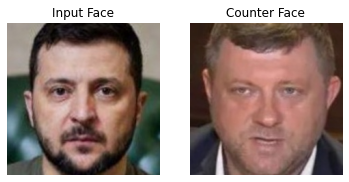

In [5]:
## Visualize the input image
image_V = Image.open(image_path)
counter_face_V = Image.open(counter_face_path)

plt.figure()

# Input face 
ax = plt.subplot(121)
plt.axis('off')
plt.imshow(image_V)
ax.set_title('Input Face')

# Counter face
ax = plt.subplot(122)
plt.axis('off')
plt.imshow(counter_face_V)
ax.set_title('Counter Face')

## 2. Load the networks and components

In [6]:
# Load Identification Network
recognition_net = get_network(id_net)
if torch.cuda.is_available():
    recognition_net.cuda()
recognition_net.eval()
print("Load the identification net")

# Load Attribute Network
attribute_net = get_network(None, "./pre-trained/Face-Attributes2.pth")
if torch.cuda.is_available():
    attribute_net.cuda()
attribute_net.eval()
print("Load the attribute net")

# Load Verification Network
verification_net = get_network(ver_net) 

seg_attr = Segmantically_Attributes(recognition_net, attribute_net, "GradCAM")

Load the identification net
Model parameters: ./pre-trained/Face-Attributes2.pth has been load!
Load the attribute net


## 3. Compute the heatmap

In [7]:
# Preproccessing
image1 = Path_Image_Preprocessing(id_net, image_path).numpy()
image2 = Path_Image_Preprocessing(id_net, counter_face_path).numpy()

In [8]:
seg_attr_interpretable1, index1, index2, attribute_id1, scores_attr1, mask1, mask2, counterfactual_map, attribute_map = seg_attr.topk_Identity_Segmantically_Attributes_Interpretable(image1, image2, 1, visualization = True)

In [9]:
def norm_image(image):
    """
    Normalization image
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

def generate_heatmap(image_input, mask):
    '''
    Save the heatmap of ones
    '''
    # Read image
    image = cv2.imread(image_input)
    # print(np.max(mask))
    masks = (mask * 255).astype(np.uint8)
    # masks = norm_image(mask).astype(np.uint8)
    # mask->heatmap
    heatmap = cv2.applyColorMap(masks, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap)
    # merge heatmap to original image
    cam = 0.5*heatmap + 0.5*np.float32(image)
    return cam.astype(np.uint8)

def cv2image(image):
    pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return pil_img

## 4. Visualize the ID map

In [10]:
ID_heatmap_visualization = cv2image(generate_heatmap(image_path, mask1))
Counter_ID_heatmap_visualization = cv2image(generate_heatmap(image_path, mask2))
CounterfactualMap = cv2image(generate_heatmap(image_path, counterfactual_map))

In [11]:
ID_heatmap_visualization.save("./images/results/Зеленский_Ht.jpg")
Counter_ID_heatmap_visualization.save("./images/results/Зеленский_Hf.jpg")
CounterfactualMap.save("./images/results/Зеленский_Hd.jpg")

Text(0.5, 1.0, 'Counterfactual MAP')

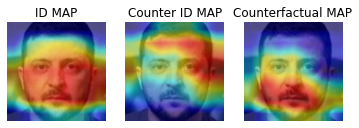

In [12]:
## Visualize the map
plt.figure()

# ID MAP
ax = plt.subplot(131)
plt.axis('off')
plt.imshow(ID_heatmap_visualization)
ax.set_title('ID MAP')

# Counter MAP
ax = plt.subplot(132)
plt.axis('off')
plt.imshow(Counter_ID_heatmap_visualization)
ax.set_title('Counter ID MAP')

# Counterfactual MAP
ax = plt.subplot(133)
plt.axis('off')
plt.imshow(CounterfactualMap)
ax.set_title('Counterfactual MAP')

## Visualize the Attribute Map

In [13]:
def imshow_attributes_heatmap(image_input, attr_idx, masks):
    '''
    Save the attributes heatmap
    '''
    num = masks.shape[0]

    attribute_name = []
    heatmap_image = []
    
    for i in range(0,num):
        # Choose the exist attribute
        if Face_attributes_name[i] in ["Gender","Age","Race","Hair_color"] or attr_idx[i] == 0:
            if Face_attributes_name[i] == "Gender":
                attr_name = Gender[attr_idx[i]]
            elif Face_attributes_name[i] == "Age":
                attr_name = Age[attr_idx[i]]
            elif Face_attributes_name[i] == "Race":
                attr_name = Race[attr_idx[i]]
            else:
                attr_name = Face_attributes_name[i]
            
            attribute_name.append(attr_name)
            heatmap_image.append(cv2image(generate_heatmap(image_input, masks[i])))
    plt.figure(figsize=(24,24))
    for i in range(len(attribute_name)):
        ax = plt.subplot(1, len(attribute_name), i+1)
        plt.axis('off')
        plt.imshow(heatmap_image[i])
        ax.set_title(attribute_name[i])

    return attribute_name, heatmap_image

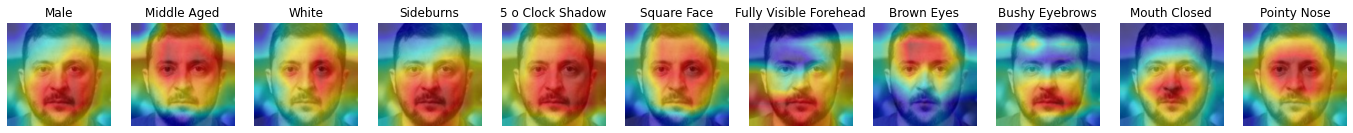

In [14]:
attribute_name, heatmap_image = imshow_attributes_heatmap(image_path, attribute_id1, attribute_map)

## Visualize the Joint Attribute MAP

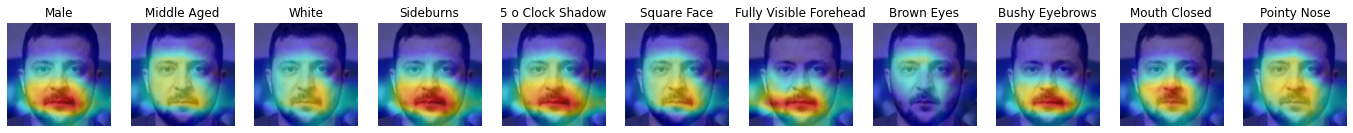

In [15]:
attribute_name, heatmap_image = imshow_attributes_heatmap(image_path, attribute_id1, seg_attr_interpretable1)

In [16]:
# save results
for i in range(len(attribute_name)):
    heatmap_image[i].save("./images/results/Joint_representation_MAP/{}.jpg".format(attribute_name[i]))

## Remove

In [17]:
def Erasing(image, mask, method):
    '''
    image: (H,W,3)
    mask: (H,W) saved pixels set 1
    method: black, white, mean, random
    '''
    if method == "black":
        image_mask = (image.transpose(2,0,1) * mask).transpose(1,2,0)
    elif method == "white":
        mask_white = np.ones(mask.shape) * (1-mask) * 255
        image_mask = (image.transpose(2,0,1) * mask + mask_white).transpose(1,2,0)
    elif method == "mean":
        mask_mean = np.ones(mask.shape) * (1-mask) * 125
        image_mask = (image.transpose(2,0,1) * mask + mask_mean).transpose(1,2,0)
    elif method == "random":
        mask_random = np.ones(mask.shape) * (1 - mask) * np.random.randint(0,256,(3, mask.shape[0], mask.shape[1]))
        mask_random = mask_random.transpose(1,2,0)
        image_mask = (image.transpose(2,0,1) * mask).transpose(1,2,0) + mask_random
    return image_mask.astype(np.uint8)

In [18]:
# Ensure where to remove
remove_seg = 1 - seg_attr_interpretable1
remove_seg[remove_seg < erase_threshold] = 0
remove_seg[remove_seg > erase_threshold] = 1

In [19]:
org_image = cv2.imread(image_path)
erasing_images = []
for i in range(len(remove_seg)):
    erasing_images.append(
        Erasing(org_image,
                remove_seg[i],
                "black"))

In [20]:
def imshow_removed_image(erasing_images, attr_idx):
    '''
    showing the erased images
    '''
    num = len(erasing_images)

    attribute_name = []
    erased_image = []
    
    for i in range(num):
        # Choose the exist attribute
        if Face_attributes_name[i] in ["Gender","Age","Race","Hair_color"] or attr_idx[i] == 0:
            if Face_attributes_name[i] == "Gender":
                attr_name = Gender[attr_idx[i]]
            elif Face_attributes_name[i] == "Age":
                attr_name = Age[attr_idx[i]]
            elif Face_attributes_name[i] == "Race":
                attr_name = Race[attr_idx[i]]
            else:
                attr_name = Face_attributes_name[i]
            
            attribute_name.append(attr_name)
            erased_image.append(erasing_images[i])
    plt.figure(figsize=(24,24))
    for i in range(len(attribute_name)):
        ax = plt.subplot(1, len(attribute_name), i+1)
        plt.axis('off')
        plt.imshow(cv2image(erased_image[i]))
        ax.set_title(attribute_name[i])

    return attribute_name, erased_image

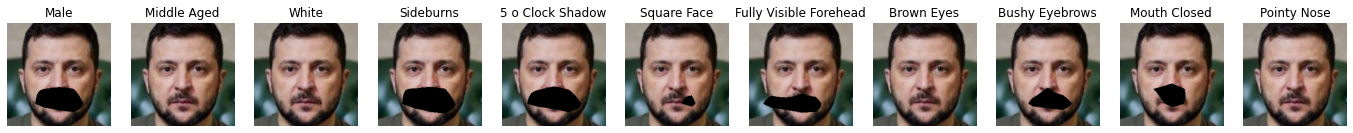

In [21]:
attribute_names, erased_images = imshow_removed_image(erasing_images, attribute_id1)

## Sort the most characteristic attribute

In [22]:
def similarity_compute(image1, image2):
    # normalization
    feature1 = F.normalize(verification_net(torch.unsqueeze(image1, dim=0).cuda()),p=2,dim=1)
    feature2 = F.normalize(verification_net(torch.unsqueeze(image2, dim=0).cuda()),p=2,dim=1)
    # similarity
    similarity = torch.cosine_similarity(feature1[0], feature2[0], dim=0).item()

    return similarity

In [23]:
# image2 is the original image
image1_ver = Path_Image_Preprocessing(ver_net, image_path)
image2_ver = Path_Image_Preprocessing(ver_net, counter_face_path)

original_similarity = similarity_compute(image1_ver, image2_ver)

similarities = []
for erased_image in erased_images:
    # preproccessing
    erased_image_proccess = Image_Preprocessing(ver_net, erased_image)
    # compute similarity
    similarities.append(
        similarity_compute(erased_image_proccess, image2_ver)
    )

In [24]:
# sort
similarities = np.array(similarities)
attribute_names = np.array(attribute_names)
idx = similarities.argsort()[::-1]

# Append the original image similaryty
similarities = np.insert(similarities[idx], 0, original_similarity)
attribute_names = np.insert(attribute_names[idx], 0, "Original")

# Valid attributes
up_id = (similarities[1:] > similarities[0]).sum()

In [25]:
similarities[1:] > similarities[0]

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False])

In [26]:
attribute_names[1:]

array(['Mouth Closed', 'Bushy Eyebrows', 'Square Face', 'Male',
       'Sideburns', '5 o Clock Shadow', 'Pointy Nose', 'Brown Eyes',
       'Middle Aged', 'White', 'Fully Visible Forehead'], dtype='<U22')

<ipython-input-27-706322181ff6>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(attribute_names, fontsize=24,rotation=60)


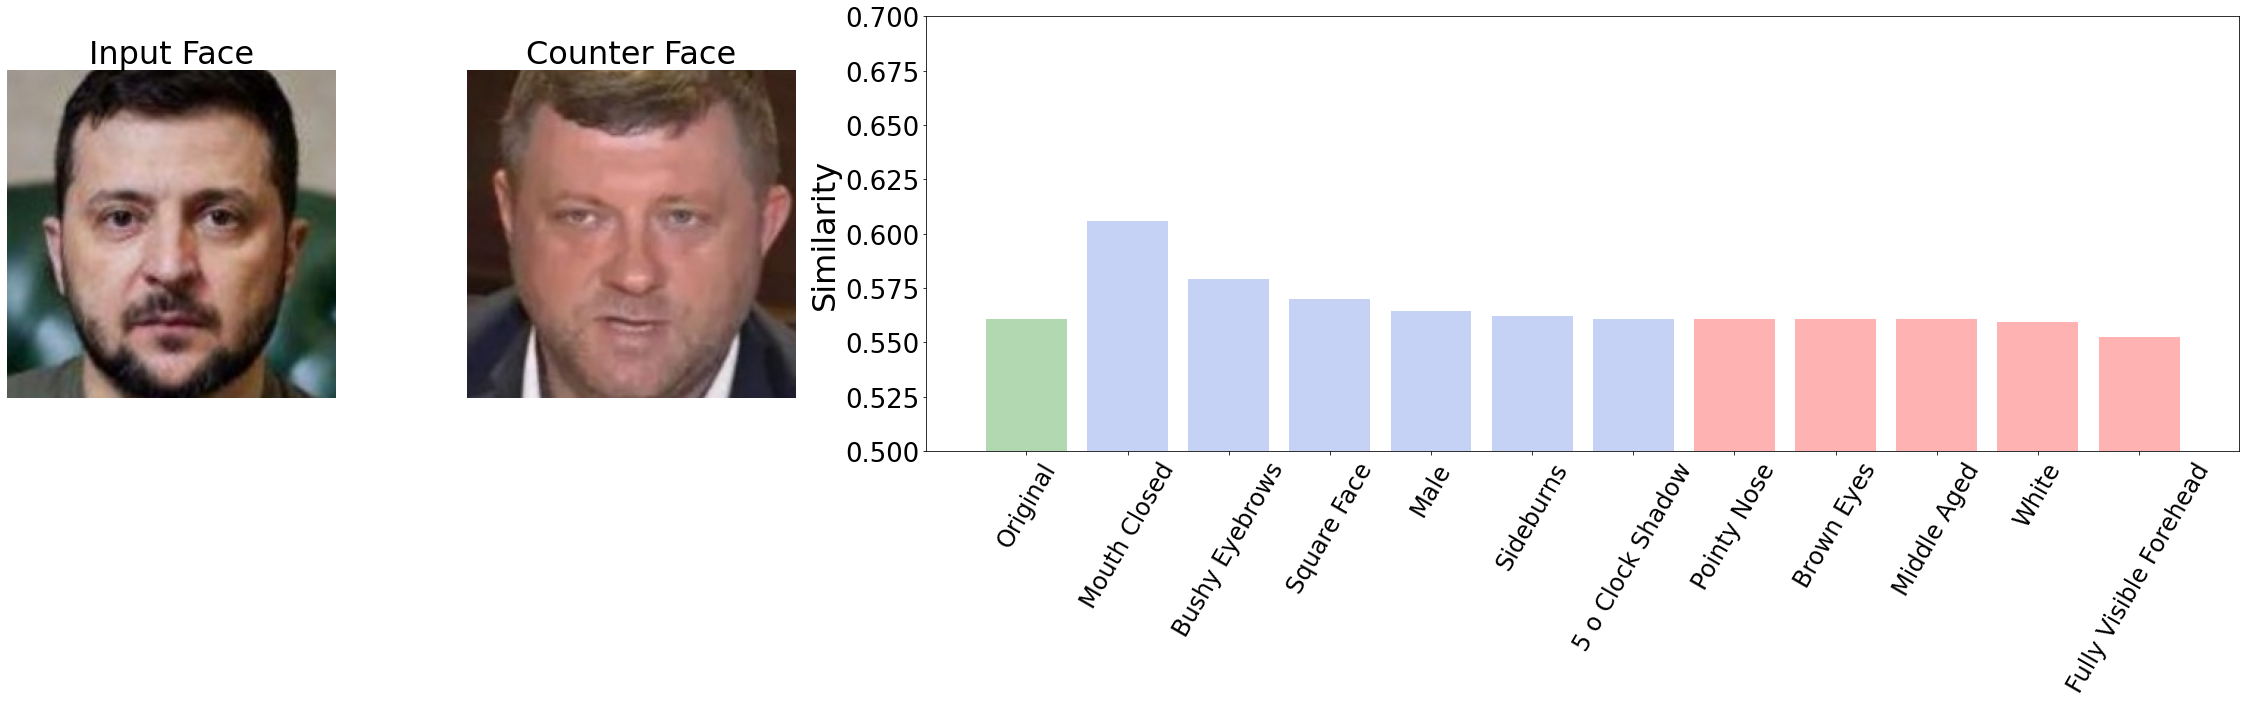

In [27]:
# Plt the image
fig, [ax1, ax2, ax3] = plt.subplots(1,3, gridspec_kw = {'width_ratios':[1, 1, 4]}, figsize=(40,8))
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.imshow(image_V)
ax1.set_title('Input Face', fontsize=32)

ax2.spines["left"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.imshow(counter_face_V)
ax2.set_title('Counter Face', fontsize=32)

ax3.bar(attribute_names[0], similarities[0], color="green",alpha = 0.3)
ax3.bar(attribute_names[1:up_id+1], similarities[1:up_id+1],color="royalblue",alpha = 0.3)
ax3.bar(attribute_names[up_id+1:], similarities[up_id+1:],color="red",alpha = 0.3)
# ax2.bar(attribute[0], uncertain_value[0], color="green",alpha = 0.2)
ax3.set_xticklabels(attribute_names, fontsize=24,rotation=60)
# plt.ylim((round(uncertain_value.min(), 4)-1e-4, round(uncertain_value.max(), 4)+1e-4))
plt.ylim((
    int(similarities.min()*10)/10, 
    math.ceil(similarities.max()*10)/10))
plt.yticks(fontsize=26)
plt.ylabel("Similarity",fontsize=32)
plt.savefig("images/results/sort.jpg",bbox_inches='tight')

Text(0.5, 1.0, 'Most characteristic attribute: Mouth Closed')

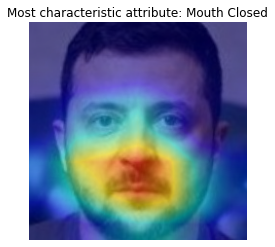

In [28]:
# Most characteristic attribute
plt.figure()
plt.axis('off')
plt.imshow(heatmap_image[idx[0]])
plt.title("Most characteristic attribute: {}".format(attribute_name[idx[0]]))